In [1]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
#from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [420]:
df = pd.read_excel('date_profit.xlsx')

In [218]:
df

,date_month,profit_month,cost_month
0,12/29/2018,724231.31,3792383.51
1,1/29/2019,493204.90,3792383.51
2,2/19/2019,429420.62,2402359.00
3,3/19/2019,692753.62,2092407.37
4,4/19/2019,648258.30,3479483.15
5,5/19/2019,1305278.37,3177423.67
6,6/19/2019,1084227.41,6386956.53
7,7/19/2019,580316.12,5554381.80
8,8/19/2019,788191.58,2857134.02
9,9/19/2019,744434.48,4081868.97


In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date_month    24 non-null     object 
 1   profit_month  24 non-null     float64
 2   cost_month    24 non-null     float64
dtypes: float64(2), object(1)
memory usage: 704.0+ bytes


In [421]:
df['date_month'] = pd.to_datetime(df['date_month'], format = '%m/%d/%Y')

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_month    25 non-null     datetime64[ns]
 1   profit_month  25 non-null     float64       
 2   cost_month    25 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 728.0 bytes


In [422]:
df = df.set_index("date_month")
df.head()

,profit_month,cost_month
date_month,,
2018-12-29,724231.31,3792383.51
2019-01-29,493204.90,3792383.51
2019-02-19,429420.62,2402359.00
2019-03-19,692753.62,2092407.37
2019-04-19,648258.30,3479483.15


In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2019-01-29 to 2020-12-20
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   profit_month  24 non-null     float64
 1   cost_month    24 non-null     float64
dtypes: float64(2)
memory usage: 576.0 bytes


In [423]:
df = df.asfreq('MS', method='ffill')

In [424]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2019-01-01 to 2020-12-01
Freq: MS
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   profit_month  24 non-null     float64
 1   cost_month    24 non-null     float64
dtypes: float64(2)
memory usage: 576.0 bytes


In [425]:
#profit
df1 = df.drop('cost_month', axis = 1)

#cost
df2 = df.drop('profit_month', axis = 1)
df1

,profit_month
date_month,
2019-01-01,724231.31
2019-02-01,493204.90
2019-03-01,429420.62
2019-04-01,692753.62
2019-05-01,648258.30
2019-06-01,1305278.37
2019-07-01,1084227.41
2019-08-01,580316.12
2019-09-01,788191.58


In [426]:
#profit
train_data1 = df1[:len(df1)-12]
test_data1 = df1[len(df1)-12:]

#cost
train_data2 = df2[:len(df2)-12]
test_data2 = df2[len(df2)-12:]

### ARIMA

In [49]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.7 MB/s eta 0:00:00


In [103]:
from pmdarima import auto_arima

In [261]:
df2['cost_month']

date_month
2019-01-01    3792383.51
2019-02-01    3792383.51
2019-03-01    2402359.00
2019-04-01    2092407.37
2019-05-01    3479483.15
2019-06-01    3177423.67
2019-07-01    6386956.53
2019-08-01    5554381.80
2019-09-01    2857134.02
2019-10-01    4081868.97
2019-11-01    3627715.07
2019-12-01    2479030.95
2020-01-01    7199102.47
2020-02-01    4291060.81
2020-03-01    1643662.49
2020-04-01    2983600.07
2020-05-01    3372878.32
2020-06-01    4623092.12
2020-07-01    5971093.39
2020-08-01    4402567.07
2020-09-01    3945548.85
2020-10-01    3114973.72
2020-11-01    4030025.89
2020-12-01    3947059.71
Freq: MS, Name: cost_month, dtype: float64

In [481]:
try:
    arima_model = auto_arima(df2['cost_month'], seasonal=True, m=6, max_p=7, max_d=1, max_q=7, max_P=4, max_D=1, max_Q=4)
    print(arima_model.summary())
except Exception as e:
    print("Error:", e)

                                SARIMAX Results                                
Dep. Variable:                       y   No. Observations:                   24
Model:             SARIMAX(0, 1, 0, 6)   Log Likelihood                -278.623
Date:                 Sat, 18 May 2024   AIC                            561.245
Time:                         12:06:52   BIC                            563.026
Sample:                     01-01-2019   HQIC                           561.491
                          - 12-01-2020                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.708e+05   3.25e+05      1.142      0.253   -2.65e+05    1.01e+06
sigma2      1.631e+12   9.27e+11      1.760      0.078   -1.86e+11    3.45e+12
Ljung-Box (L1) (Q):                   0.22  

In [493]:
arima_model = SARIMAX(train_data2['cost_month'], order = (1,1,0), seasonal_order = (0,1,1,6))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          cost_month   No. Observations:                   12
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 6)   Log Likelihood                 -77.427
Date:                             Sat, 18 May 2024   AIC                            160.855
Time:                                     12:10:09   BIC                            159.683
Sample:                                 01-01-2019   HQIC                           157.710
                                      - 12-01-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2461      0.824     -0.299      0.765      -1.861       1.369
ma.S.L6       -0.2385      1.142     -0.209      0.835      -2.478       2.001
sigma2      1.896e+12   2.85e-13   6.66e+24      0.000     1.9e+12     1.9e+12
===================================================================================
Ljung-Box (L1) (Q):                   2.10   Jarque-Bera (JB):                 0.97
Prob(Q):                              0.15   Prob(JB):                         0.62
Heteroskedasticity (H):               0.80   Skew:                             1.07
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.57e+41. Standard errors may be unstable.
"""

In [503]:
arima_pred2 = arima_result.predict(start = len(train_data2), end = len(df2)+11, typ="levels").rename("ARIMA Predictions")
arima_pred2

2020-01-01    5.860004e+06
2020-02-01    5.167271e+06
2020-03-01    2.869536e+06
2020-04-01    3.743195e+06
2020-05-01    3.650419e+06
2020-06-01    2.730548e+06
2020-07-01    6.055221e+06
2020-08-01    5.376341e+06
2020-09-01    3.075198e+06
2020-10-01    3.949695e+06
2020-11-01    3.856713e+06
2020-12-01    2.936893e+06
2021-01-01    6.261553e+06
2021-02-01    5.582676e+06
2021-03-01    3.281532e+06
2021-04-01    4.156030e+06
2021-05-01    4.063047e+06
2021-06-01    3.143228e+06
2021-07-01    6.467888e+06
2021-08-01    5.789011e+06
2021-09-01    3.487867e+06
2021-10-01    4.362364e+06
2021-11-01    4.269382e+06
2021-12-01    3.349562e+06
Freq: MS, Name: ARIMA Predictions, dtype: float64

In [504]:
arima_pred2.to_excel('arima_predictions_cost.xlsx')

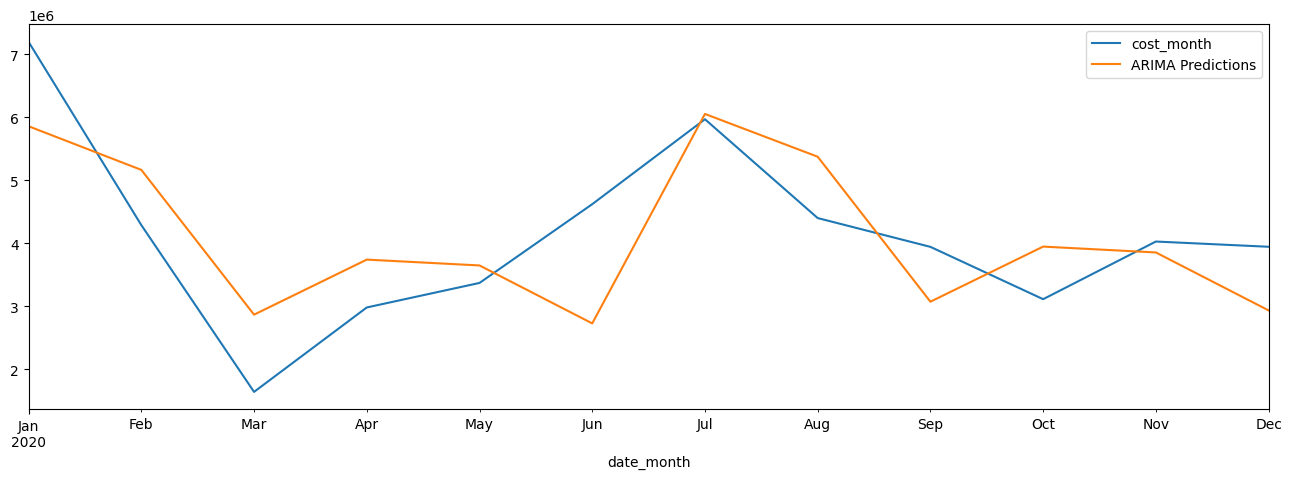

In [495]:
test_data2['cost_month'].plot(figsize = (16,5), legend=True)
arima_pred2.plot(legend = True);

In [498]:
mean_pred2 = arima_pred2.mean()
mean_pred2

4311882.303867419

In [502]:
arima_rmse_error2 = rmse(test_data2['cost_month'], arima_pred2)
arima_mse_error2 = arima_rmse_error2**2
mean_value2 = df2['cost_month'].mean()
mean_pred2 = arima_pred2.mean()

print(f'MSE Error: {arima_mse_error2}\nRMSE Error: {arima_rmse_error2}\nMean: {mean_value2}\nMean Pred: {mean_pred2}')

MSE Error: 979957381721.5284
RMSE Error: 989927.967945915
Mean: 3885341.3525000005
Mean Pred: 4105919.555397889


In [476]:
arima_model = SARIMAX(train_data1['profit_month'], order = (0,0,1), seasonal_order = (0,1,1,12))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       profit_month   No. Observations:                   12
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Sat, 18 May 2024   AIC                              6.000
Time:                                    12:03:38   BIC                               -inf
Sample:                                01-01-2019   HQIC                               nan
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1               0        nan        nan        nan         nan         nan
ma.S.L12            0        nan        nan        nan         nan         nan
sigma2         1.0000        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

In [479]:
arima_pred1 = arima_result.predict(start = len(train_data1), end = len(df1)+11, typ="levels").rename("ARIMA Predictions")
arima_pred1

2020-01-01     724231.31
2020-02-01     493204.90
2020-03-01     429420.62
2020-04-01     692753.62
2020-05-01     648258.30
2020-06-01    1305278.37
2020-07-01    1084227.41
2020-08-01     580316.12
2020-09-01     788191.58
2020-10-01     744434.48
2020-11-01     482287.62
2020-12-01    1514673.56
2021-01-01     724231.31
2021-02-01     493204.90
2021-03-01     429420.62
2021-04-01     692753.62
2021-05-01     648258.30
2021-06-01    1305278.37
2021-07-01    1084227.41
2021-08-01     580316.12
2021-09-01     788191.58
2021-10-01     744434.48
2021-11-01     482287.62
2021-12-01    1514673.56
Freq: MS, Name: ARIMA Predictions, dtype: float64

In [480]:
arima_pred1.to_excel('arima_predictions_profit.xlsx')

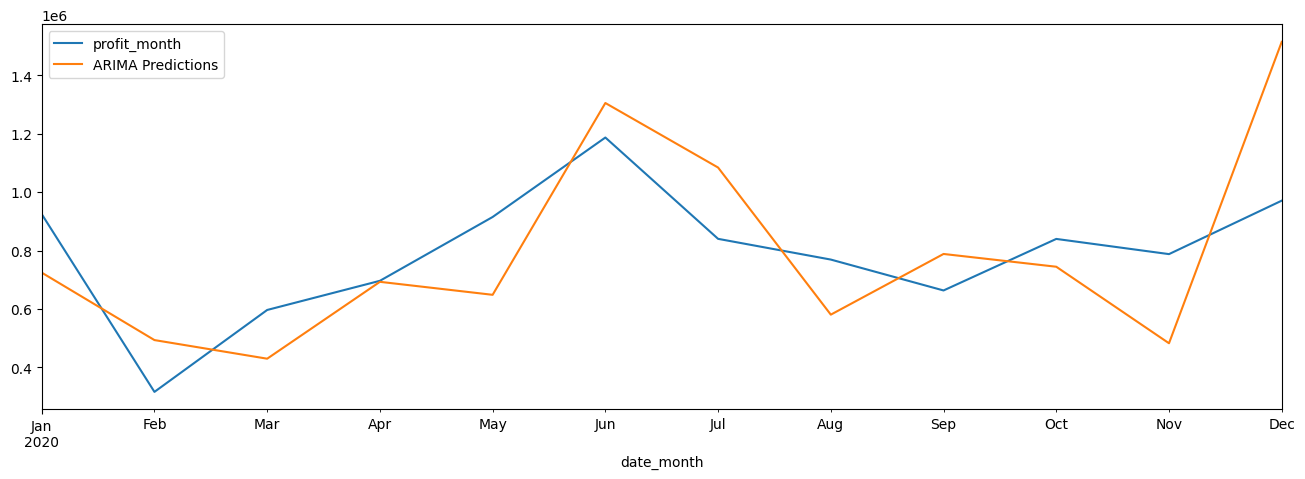

In [478]:
test_data1['profit_month'].plot(figsize = (16,5), legend=True)
arima_pred1.plot(legend = True);

In [385]:
arima_rmse_error1 = rmse(test_data1['profit_month'], arima_pred1)
arima_mse_error1 = arima_rmse_error1**2
mean_value1 = df1['profit_month'].mean()
mean_pred1 = arima_pred1.mean()

print(f'MSE Error: {arima_mse_error1}\nRMSE Error: {arima_rmse_error1}\nMean: {mean_value1}\nMean Pred: {mean_pred1}')

MSE Error: 48338209522.99847
RMSE Error: 219859.52224772633
Mean: 791351.1549999999
Mean Pred: 828325.4602210056


## LSTM

In [235]:
#LSTM
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [238]:
#profit
scaler.fit(train_data1)
scaled_train_data1 = scaler.transform(train_data1)
scaled_test_data1 = scaler.transform(test_data1)

In [237]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 11
n_features= 1

#profit
generator1 = TimeseriesGenerator(scaled_train_data1, scaled_train_data1, length=n_input, batch_size=1)


In [239]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               161600    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161801 (632.04 KB)
Trainable params: 161801 (632.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [240]:
#profit
lstm_model.fit_generator(generator1,epochs=20)

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.9740
Epoch 2/20
1/1 [==============================] - 0s 30ms/step - loss: 0.9407
Epoch 3/20
1/1 [==============================] - 0s 29ms/step - loss: 0.9077
Epoch 4/20
1/1 [==============================] - 0s 29ms/step - loss: 0.8736
Epoch 5/20
1/1 [==============================] - 0s 31ms/step - loss: 0.8368
Epoch 6/20
1/1 [==============================] - 0s 33ms/step - loss: 0.7967
Epoch 7/20
1/1 [==============================] - 0s 33ms/step - loss: 0.7528
Epoch 8/20
1/1 [==============================] - 0s 32ms/step - loss: 0.7036
Epoch 9/20
1/1 [==============================] - 0s 29ms/step - loss: 0.6481
Epoch 10/20
1/1 [==============================] - 0s 29ms/step - loss: 0.5847
Epoch 11/20
1/1 [==============================] - 0s 32ms/step - loss: 0.5123
Epoch 12/20
1/1 [==============================] - 0s 30ms/step - loss: 0.4300
Epoch 13/20
1/1 [==============================] - 0s 33ms/step

In [241]:
losses_lstm1 = lstm_model.history.history['loss']

In [242]:
lstm_predictions_scaled1 = list()

batch1 = scaled_train_data1[-n_input:]
current_batch1 = batch1.reshape((1, n_input, n_features))

for i in range(len(test_data1)):
    lstm_pred1 = lstm_model.predict(current_batch1)[0]
    lstm_predictions_scaled1.append(lstm_pred1)
    current_batch1 = np.append(current_batch1[:,1:,:],[[lstm_pred1]],axis=1)

1/1 [==============================] - 0s 128ms/step


In [243]:
lstm_predictions_scaled1

[array([1.2999164], dtype=float32),
 array([1.4706672], dtype=float32),
 array([1.7275804], dtype=float32),
 array([1.987921], dtype=float32),
 array([2.3773346], dtype=float32),
 array([2.52676], dtype=float32),
 array([2.8977532], dtype=float32),
 array([3.797715], dtype=float32),
 array([5.0834303], dtype=float32),
 array([7.3692093], dtype=float32),
 array([12.31245], dtype=float32),
 array([19.754988], dtype=float32)]

In [244]:
lstm_predictions1 = scaler.inverse_transform(lstm_predictions_scaled1)
lstm_predictions1

array([[ 1840158.7003165 ],
       [ 2025466.56923162],
       [ 2304282.35870746],
       [ 2586817.72922439],
       [ 3009429.97829071],
       [ 3171594.44863045],
       [ 3574215.8416698 ],
       [ 4550901.93330889],
       [ 5946228.28774866],
       [ 8426876.6669603 ],
       [13791543.6249015 ],
       [21868579.11918522]])

In [245]:
test_data1['LSTM_Predictions'] = lstm_predictions1
test_data1

,profit_month,LSTM_Predictions
date_month,,
2020-01-01,924639.02,1.840159e+06
2020-02-01,315750.51,2.025467e+06
2020-03-01,596343.77,2.304282e+06
2020-04-01,696219.46,2.586818e+06
2020-05-01,914851.65,3.009430e+06
2020-06-01,1187044.47,3.171594e+06
2020-07-01,839989.39,3.574216e+06
2020-08-01,768976.36,4.550902e+06
2020-09-01,663167.65,5.946228e+06


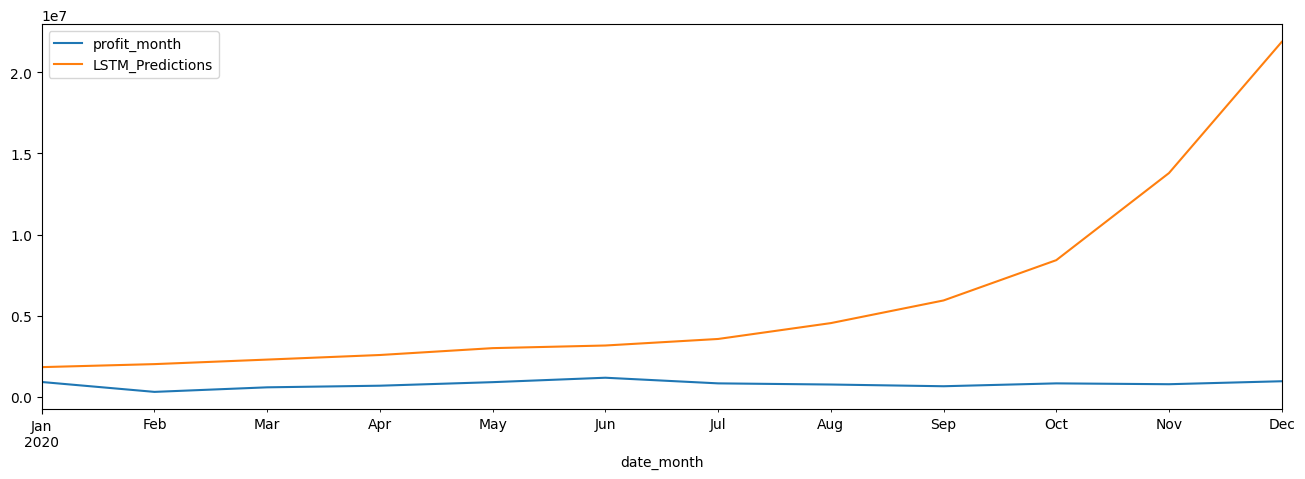

In [246]:
test_data1['profit_month'].plot(figsize = (16,5), legend=True)
test_data1['LSTM_Predictions'].plot(legend = True);

In [47]:
lstm_rmse_error1 = rmse(test_data1['profit_month'], test_data1["LSTM_Predictions"])
lstm_mse_error1 = lstm_rmse_error1**2
mean_value1 = df1['profit_month'].mean()
mean_lstm1 = test_data1["LSTM_Predictions"].mean()

print(f'MSE Error: {lstm_mse_error1}\nRMSE Error: {lstm_rmse_error1}\nMean: {mean_value1}\nMean LSTM: {mean_lstm1}')

MSE Error: 30903721956712.918
RMSE Error: 5559111.615781151
Mean: 791351.1549999999
Mean LSTM: 4789173.1337115755


### Prophet

In [9]:
df_pr = df.copy()
df_pr = df.reset_index()

#### Profit

In [10]:
df_pr1 = df_pr.drop('cost_month', axis = 1)

In [11]:
df_pr1.columns = ['ds','y']

In [12]:
train_data_pr1 = df_pr1.iloc[:len(df)-12]
test_data_pr1 = df_pr1.iloc[len(df)-12:]

In [13]:
!pip install prophet

In [14]:
from prophet import Prophet

In [15]:
m = Prophet()
m.fit(train_data_pr1)
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred1 = m.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_e7xpfxw/ontpyw50.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_e7xpfxw/aa8an0qu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39263', 'data', 'file=/tmp/tmp_e7xpfxw/ontpyw50.json', 'init=/tmp/tmp_e7xpfxw/aa8an0qu.json', 'output', 'file=/tmp/tmp_e7xpfxw/prophet_model0nne38mp/prophet_model-20240518095407.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:54:07 - cmdstanpy - INFO - Chain [1] start processing
IN

In [16]:
prophet_pred1.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
19,2020-08-01,1.282094e+06,8.839813e+05,1.667685e+06,1.282094e+06,1.282094e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.282094e+06
20,2020-09-01,1.320964e+06,9.575819e+05,1.719520e+06,1.320964e+06,1.320964e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.320964e+06
21,2020-10-01,1.358580e+06,9.770225e+05,1.725430e+06,1.358580e+06,1.358580e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.358580e+06
22,2020-11-01,1.397450e+06,1.038394e+06,1.781453e+06,1.397450e+06,1.397450e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.397450e+06
23,2020-12-01,1.435066e+06,1.059765e+06,1.835487e+06,1.435066e+06,1.435066e+06,0.0,0.0,0.0,0.0,0.0,0.0,1.435066e+06


In [17]:
prophet_pred1 = pd.DataFrame({"Date" : prophet_pred1[-12:]['ds'], "Pred" : prophet_pred1[-12:]["yhat"]})

In [18]:
prophet_pred1 = prophet_pred1.set_index("Date")
prophet_pred1.index.freq = "MS"
prophet_pred1

,Pred
Date,
2020-01-01,1.015020e+06
2020-02-01,1.053890e+06
2020-03-01,1.090252e+06
2020-04-01,1.129122e+06
2020-05-01,1.166738e+06
2020-06-01,1.205608e+06
2020-07-01,1.243224e+06
2020-08-01,1.282094e+06
2020-09-01,1.320964e+06


In [19]:
test_data1["Prophet_Predictions"] = prophet_pred1['Pred'].values

In [20]:
import seaborn as sns

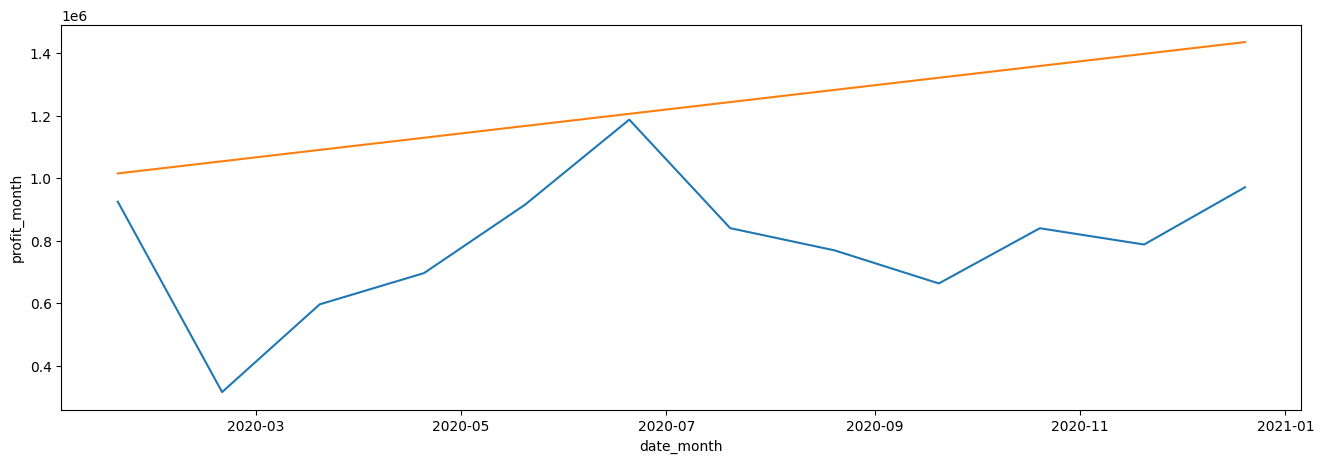

In [21]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data1.index, y=test_data1["profit_month"])
sns.lineplot(x=test_data1.index, y = test_data1["Prophet_Predictions"]);

In [24]:
prophet_rmse_error1 = rmse(test_data1['profit_month'], test_data1["Prophet_Predictions"])
prophet_mse_error1 = prophet_rmse_error1**2
mean_value1 = df1['profit_month'].mean()
mean_prophet1 = test_data1["Prophet_Predictions"].mean()

print(f'MSE Error: {prophet_mse_error1}\nRMSE Error: {prophet_rmse_error1}\nMean: {mean_value1}\nMean Prophet: {mean_prophet1}')

MSE Error: 230279839470.29788
RMSE Error: 479874.8164576861
Mean: 791351.1549999999
Mean Prophet: 1224834.1175596318
